## DSCI 100 Group Project Proposal - Section 006 Group 19 ##

By: Alessandra Lu, Ruby Suo, Han Wei, Alan Wu

### Introduction ###

In secondary education, time management plays a pivotal role in shaping the development and outcome of students. From studying for school, enjoying their leisure time, or going out with friends, high school students must find balance in their hectic schedules. How they choose to allocate their time across the various facets of their day-to-day lives may ultimately influence their academic performance and grades in school. 

Thus we pose the question: **How can we predict a student's final grade based on how they spend their time?**

We will use a data set from "Using Data Mining to Predict Secondary School Student Performance" by Paulo Cortez and Alice Silva (2008) to analyze and model how different time distributions influence a student's grade. The data illustrates the performance of Portuguese secondary school students from two schools and includes information such as student's free time, study time, final grade, and more. Researchers collected this information for Mathematics and Portuguese classes, two of the students' core courses. The original data set can be found here: https://archive.ics.uci.edu/dataset/320/student+performance

### Preliminary Exploratory Data Analysis ###

In [1]:
# Import libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Load data from the web

url <- "https://raw.githubusercontent.com/alan-w-u/dsci-100-group-project/main/student-mat.csv"
data_raw <- read_delim(url, delim = ";")
data_raw

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


In [3]:
# Clean and wrangle the data

age_range = c(15, 16, 17, 18)

data <- data_raw |>
    filter(age %in% age_range & G3 != 0) |> # Filter for student age that is normatively in secondary school and final grade is 0
    relocate(traveltime, .after = freetime) |> # Reorder table headers
    select(age, traveltime, studytime, freetime, goout, G3) |>
    rename(finalgrade = G3) |> # Rename G3 to be a more clear title
    mutate(finalgrade = finalgrade * 5)
data

age,traveltime,studytime,freetime,goout,finalgrade
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,2,2,3,4,30
17,1,2,3,3,30
15,1,2,3,2,50
⋮,⋮,⋮,⋮,⋮,⋮
18,1,2,3,4,40
17,2,1,4,5,80
18,3,1,4,1,50


In [4]:
# Split training and testing data

set.seed(1)

data_split <- initial_split(data, prop = 0.7, strata = finalgrade)
data_training <- training(data_split)
data_testing <- testing(data_split)

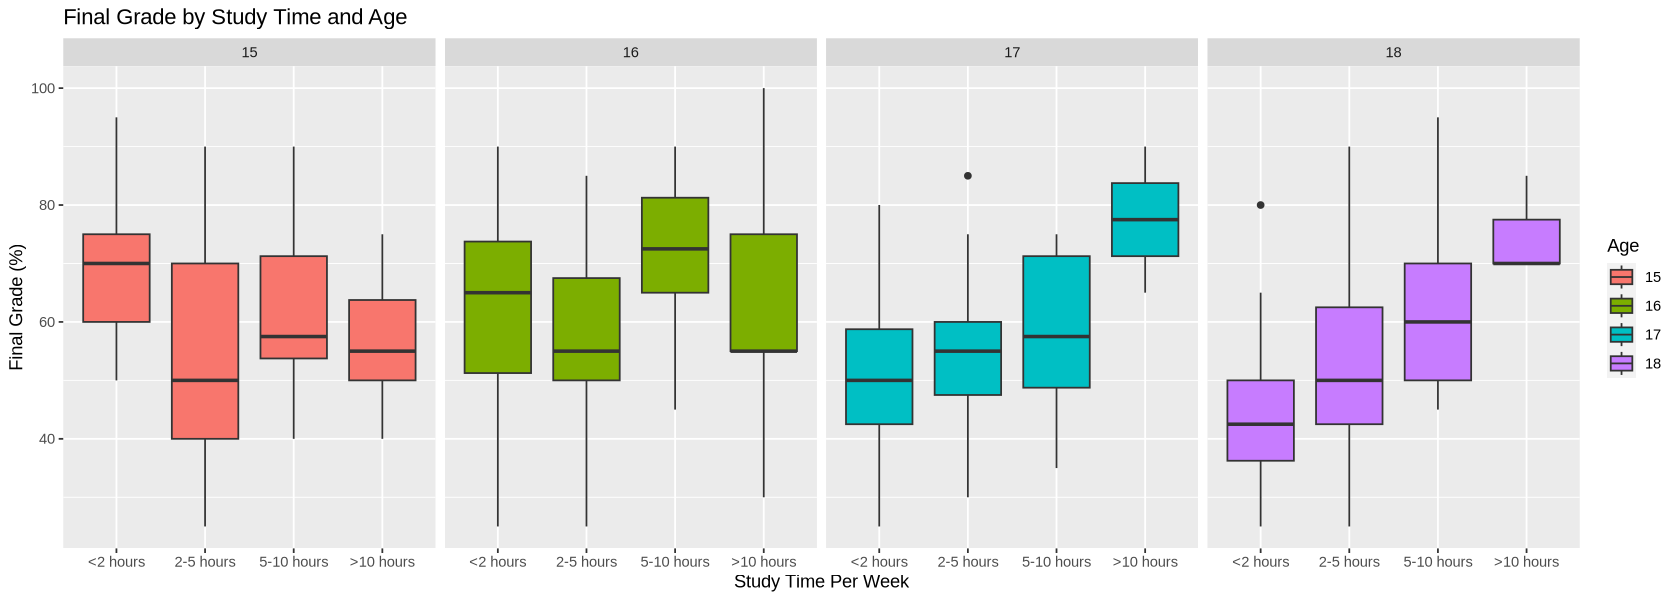

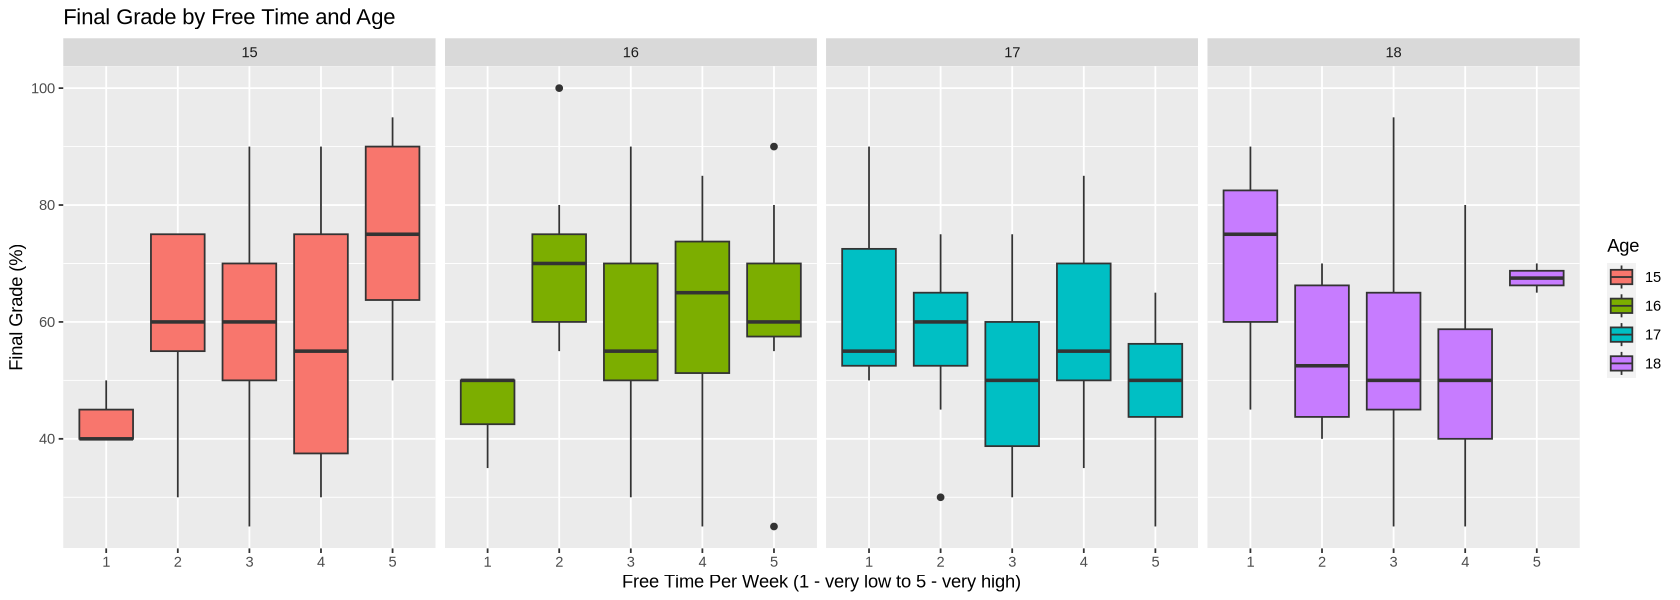

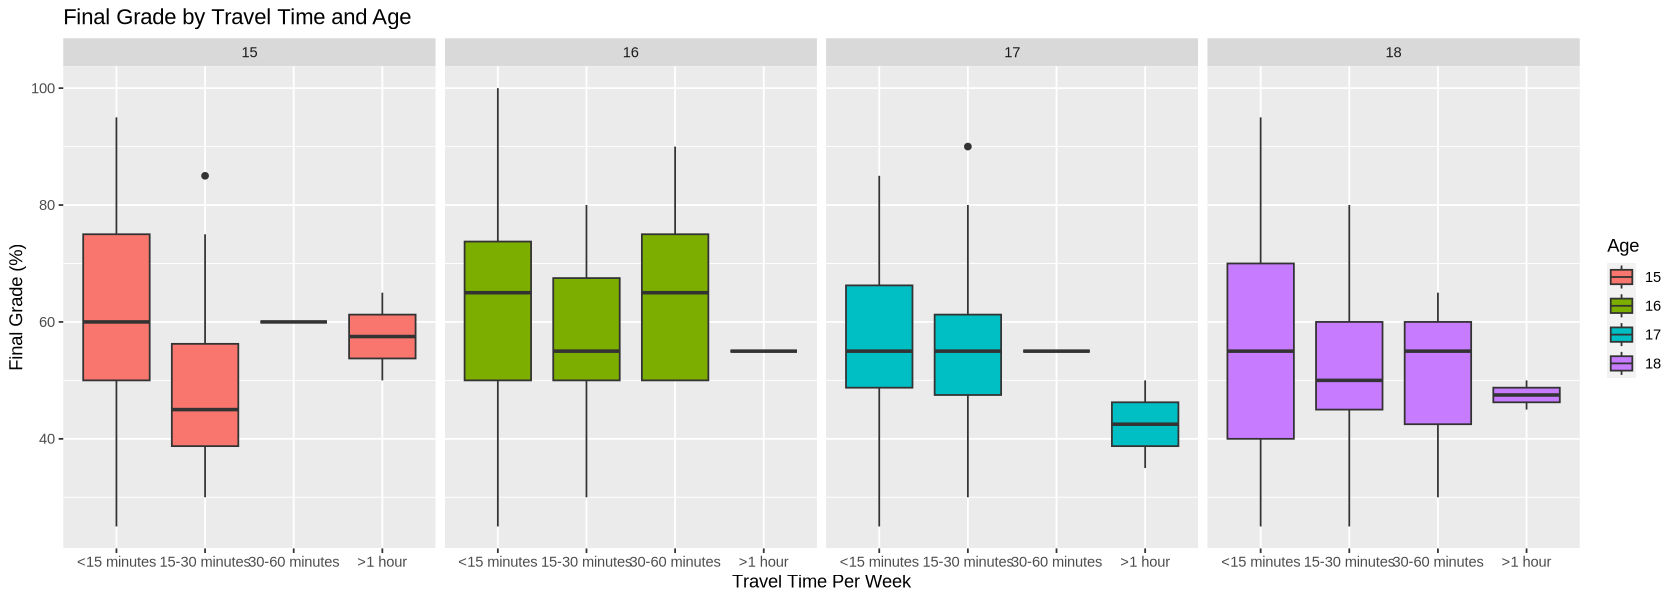

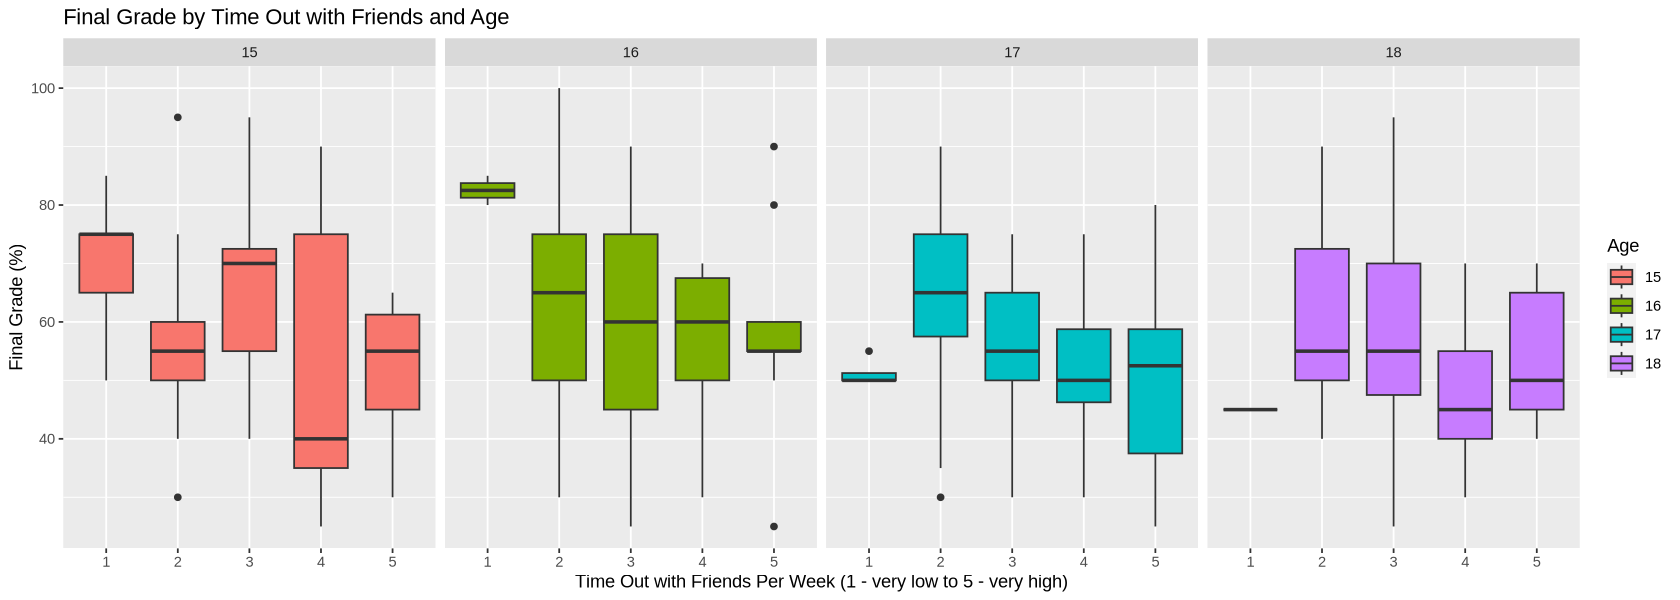

In [5]:
# Visualize data

options(repr.plot.height = 5, repr.plot.width = 14)

studytime_values <- c("1", "2", "3", "4")
studytime_meanings <- c("<2 hours", "2-5 hours", "5-10 hours", ">10 hours")

traveltime_values <- c("1", "2", "3", "4")
traveltime_meanings <- c("<15 minutes", "15-30 minutes", "30-60 minutes", ">1 hour")

data_plot_studytime <- data_training |>
    ggplot(aes(x = as_factor(studytime), y = finalgrade, fill = as_factor(age))) +
    geom_boxplot() +
    labs(x = "Study Time Per Week", y = "Final Grade (%)", fill = "Age") +
    ggtitle("Final Grade by Study Time and Age") +
    facet_grid(cols = vars(as_factor(age))) +
    scale_x_discrete(breaks = studytime_values, labels = studytime_meanings)

data_plot_freetime <- data_training |>
    ggplot(aes(x = as_factor(freetime), y = finalgrade, fill = as_factor(age))) +
    geom_boxplot() +
    labs(x = "Free Time Per Week (1 - very low to 5 - very high)", y = "Final Grade (%)", fill = "Age") +
    ggtitle("Final Grade by Free Time and Age") +
    facet_grid(cols = vars(as_factor(age)))

data_plot_traveltime <- data_training |>
    ggplot(aes(x = as_factor(traveltime), y = finalgrade, fill = as_factor(age))) +
    geom_boxplot() +
    labs(x = "Travel Time Per Week", y = "Final Grade (%)", fill = "Age") +
    ggtitle("Final Grade by Travel Time and Age") +
    facet_grid(cols = vars(as_factor(age))) +
    scale_x_discrete(breaks = traveltime_values, labels = traveltime_meanings)

data_plot_goout <- data_training |>
    ggplot(aes(x = as_factor(goout), y = finalgrade, fill = as_factor(age))) +
    geom_boxplot() +
    labs(x = "Time Out with Friends Per Week (1 - very low to 5 - very high)", y = "Final Grade (%)", fill = "Age") +
    ggtitle("Final Grade by Time Out with Friends and Age") +
    facet_grid(cols = vars(as_factor(age)))

data_plot_studytime
data_plot_freetime
data_plot_traveltime
data_plot_goout

### Methods ###

We will perform a K-nearest neighbour (knn) regression model since all the variables analyzed are numerical. The variables we will use for our model are:
- age
- study time
- free time
- travel time
- time out with friends

*Note: We filter for ages 15-18 and non-zero final grades to remove outlier cases since we want to generalize for normative high school students.*

We chose these variables because they allow us to quantify how students spend their time. We want to determine the trends and connections between different time distributions and what their final grades are. 

We will primarily visualize the data using boxplots since the five-number summary is useful for interpreting the results and since it allows us to compare the performance of different time allocations side-by-side. For all our plots, we will separate the data by age to understand these trends for different grades. We will likely use a combination of the graphs above that plot study time, free time, travel time, and time out with friends and compare them.

### Expected Outcomes and Significance ###

1. What do you expect to find?

We predict that study time will have a positive relationship with final grade while free time, travel time, and time out with friends will be negative. We also expect that the final grade will be largely determined by study time and that the average student will have a grade of ~75%.

2. What impact could such findings have?

Time management is an important skill for students to have and learn. As secondary students step into higher education, they must understand how their time allocation affects their academic performance. This analysis may provide insight as to how much time students "should" spend on their day-to-day activities.

3. What future questions could this lead to

We could pose the question "How can we encourage and build good time management skills in students?" We can also ask "How do the data and results differ between secondary and post-secondary students?"